In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [29]:
c_data = pd.read_csv('../data/data_cleaned.csv')

In [30]:
c_data.head(10)

,Bankrupt?,ROA(C)_before_interest_and_depreciation_before_interest,ROA(A)_before_interest_and_%_after_tax,ROA(B)_before_interest_and_depreciation_after_tax,Operating_Gross_Margin,Realized_Sales_Gross_Margin,Operating_Profit_Rate,Pre-tax_net_Interest_Rate,After-tax_net_Interest_Rate,Non-industry_income_and_expenditure/revenue,...,Liability-Assets_Flag,Net_Income_to_Total_Assets,Total_assets_to_GNP_price,No-credit_Interval,Gross_Profit_to_Sales,Net_Income_to_Stockholder's_Equity,Liability_to_Equity,Degree_of_Financial_Leverage_(DFL),Interest_Coverage_Ratio_(Interest_expense_to_EBIT),Equity_to_Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490
5,1,0.388680,0.415177,0.419134,0.590171,0.590251,0.998758,0.796903,0.808771,0.303116,...,0,0.710420,0.005278,0.622605,0.590172,0.829939,0.285087,0.026675,0.564538,0.019534
6,0,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,...,0,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,0.015663
7,0,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,...,0,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,0.034889
8,0,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,...,0,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,0.065826
9,0,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,...,0,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,0.030801


#### Heatmap check
We will first check the correlation between columns of the entire data-set through the Heatmap

In [31]:
corr_df = c_data.corr()

<AxesSubplot:>

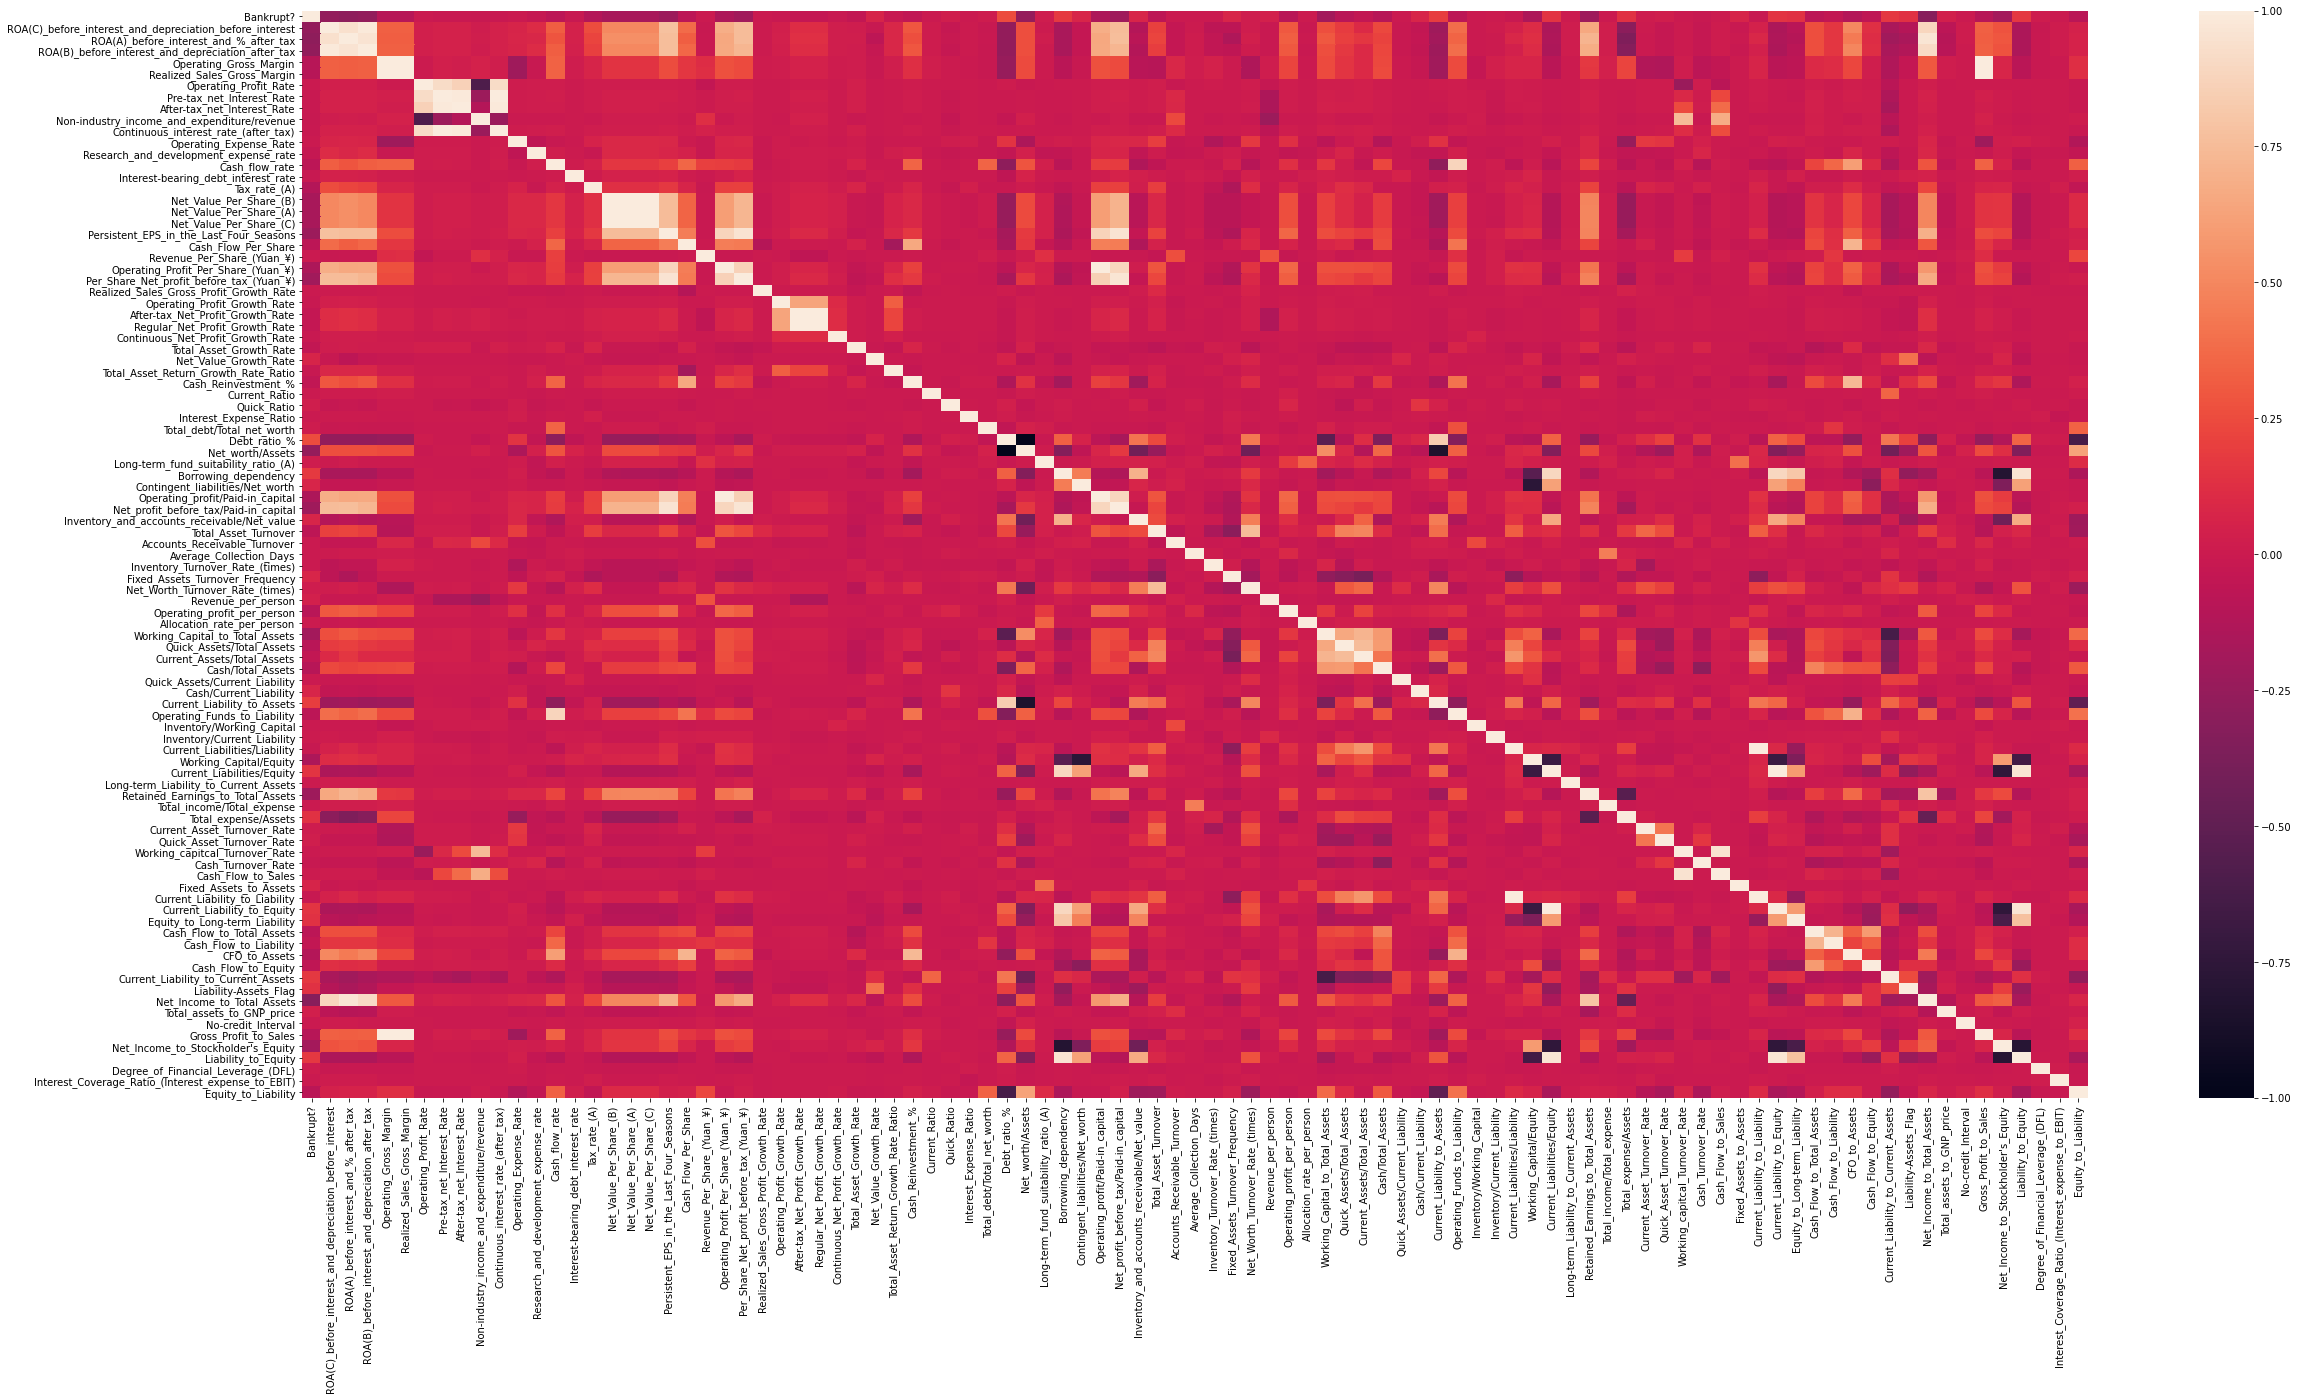

In [32]:
plt.figure(figsize=(40,20))
sns.heatmap(corr_df)

First glance through the heatmap we can notice two aspects: <br>
- There are too many features presented. Not all features will have significant influence on the analysis. Thus, we should identify which features have the least impact and to be removed from the data-set. This will be done through Feature selection. <br>
- There are variables which measures extremely close to -1 or 1. This signifies that some of the features are highly correlated with each other and are likely to have high colinearity and be redundant. 

#### Multicollinearity Check
High correlation between the indepent variables in the regression analysis could impact overall interpretation of the result.
In this case, the heatmap does not specify or show if information in the variable is explained in multiple other variables. however, the high correlated relation between the features in some groups could represent that some feature may provide redundant and duplicate infomration of each other. To address the issue, it may help to identify and drop these features that have correlation coefficient above 0.95 or below -0.95 to avoid multicollinearity in the variables.

First I will create correlation matrix by removing the target variable = Bankrupt

In [33]:
correlation_matrix = c_data.drop(['Bankrupt?'], axis =1).corr()

In [34]:
avoid_list = [] # Create empty list for columns to drop
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.95: # Check correlation coefficient above 0.95 or below -0.95
            if correlation_matrix.columns[j] not in avoid_list:
                avoid_list.append(correlation_matrix.columns[j])

In [35]:
print("The number of variables that consists of high correlation is:",len(avoid_list))

The number of variables that consists of high correlation is: 17


Now we will drop the variable from the data and create a new data-set

In [36]:
cc_data = c_data.drop(avoid_list, axis=1)
len(cc_data.columns)

78

The final number of columns after filtering the variable that could potentially have duplicate/reduant information is 78

#### Feature Selection
The data-set has large number of features. In order to make EDA easier, we need to reduce the number of features on the data.<br>
For the feature selection I have used Backward Elimination method. Backward Elimination method, which is common technique of  wrapper method, starts with all the features and removes the least significant feature at each iteration which improves the performance of the model. The process repeats until there are no further improvement observed on removal of the features. The performance metric used to evaluate the performance of the feature is by using P-value. We set the significance level and remove the feature depending on if the value is above or below.

The steps in Backward Elimination method is as follows: 
- First, select the significance level (P-value) as 5%(0.05).
- Fit the model with all the features selected.
- Identify the predictor with the highest P-value
- If the P-value identified is greater than the set significance level, we remove the feature from the column
- Once the feature is removed we fit the model again with the new data-set.
- Iterate the process until the highest P-value in the data-set is less than 0.05 and features are filtered out.

First step is to seperate the Feature Matrix(X) and Target variable(y)

In [37]:
X = cc_data.drop(['Bankrupt?'],axis=1)
y = cc_data['Bankrupt?']

In [38]:
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index=cols)
    pmax= max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features = cols

In [39]:
print("The Selected columns are: \n",selected_features)

The Selected columns are: 
 ['Operating_Profit_Rate', 'Non-industry_income_and_expenditure/revenue', 'Continuous_interest_rate_(after_tax)', 'Tax_rate_(A)', 'Net_worth/Assets', 'Contingent_liabilities/Net_worth', 'Operating_profit/Paid-in_capital', 'Inventory_and_accounts_receivable/Net_value', 'Fixed_Assets_Turnover_Frequency', 'Net_Worth_Turnover_Rate_(times)', 'Revenue_per_person', 'Operating_profit_per_person', 'Working_Capital_to_Total_Assets', 'Quick_Assets/Total_Assets', 'Current_Assets/Total_Assets', 'Cash/Current_Liability', 'Current_Liability_to_Assets', 'Operating_Funds_to_Liability', 'Retained_Earnings_to_Total_Assets', 'Cash_Turnover_Rate', 'Fixed_Assets_to_Assets', 'Current_Liability_to_Liability', 'Cash_Flow_to_Equity', 'Current_Liability_to_Current_Assets', 'Liability-Assets_Flag', 'Net_Income_to_Total_Assets', "Net_Income_to_Stockholder's_Equity", 'Liability_to_Equity', 'Equity_to_Liability']


In [40]:
print("The number of features reduced down to:", len(selected_features))

The number of features reduced down to: 29


In [41]:
new_columns = ['Bankrupt?','Operating_Profit_Rate', 'Non-industry_income_and_expenditure/revenue', 'Continuous_interest_rate_(after_tax)', 'Tax_rate_(A)', 'Net_worth/Assets', 'Contingent_liabilities/Net_worth', 'Operating_profit/Paid-in_capital', 'Inventory_and_accounts_receivable/Net_value', 'Fixed_Assets_Turnover_Frequency', 'Net_Worth_Turnover_Rate_(times)', 'Revenue_per_person', 'Operating_profit_per_person', 'Working_Capital_to_Total_Assets', 'Quick_Assets/Total_Assets', 'Current_Assets/Total_Assets', 'Cash/Current_Liability', 'Current_Liability_to_Assets', 'Operating_Funds_to_Liability', 'Retained_Earnings_to_Total_Assets', 'Cash_Turnover_Rate', 'Fixed_Assets_to_Assets', 'Current_Liability_to_Liability', 'Cash_Flow_to_Equity', 'Current_Liability_to_Current_Assets', 'Liability-Assets_Flag', 'Net_Income_to_Total_Assets', "Net_Income_to_Stockholder's_Equity", 'Liability_to_Equity', 'Equity_to_Liability']
sel_data = cc_data[new_columns]
sel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bankrupt?                                    6819 non-null   int64  
 1   Operating_Profit_Rate                        6819 non-null   float64
 2   Non-industry_income_and_expenditure/revenue  6819 non-null   float64
 3   Continuous_interest_rate_(after_tax)         6819 non-null   float64
 4   Tax_rate_(A)                                 6819 non-null   float64
 5   Net_worth/Assets                             6819 non-null   float64
 6   Contingent_liabilities/Net_worth             6819 non-null   float64
 7   Operating_profit/Paid-in_capital             6819 non-null   float64
 8   Inventory_and_accounts_receivable/Net_value  6819 non-null   float64
 9   Fixed_Assets_Turnover_Frequency              6819 non-null   float64
 10  

<AxesSubplot:>

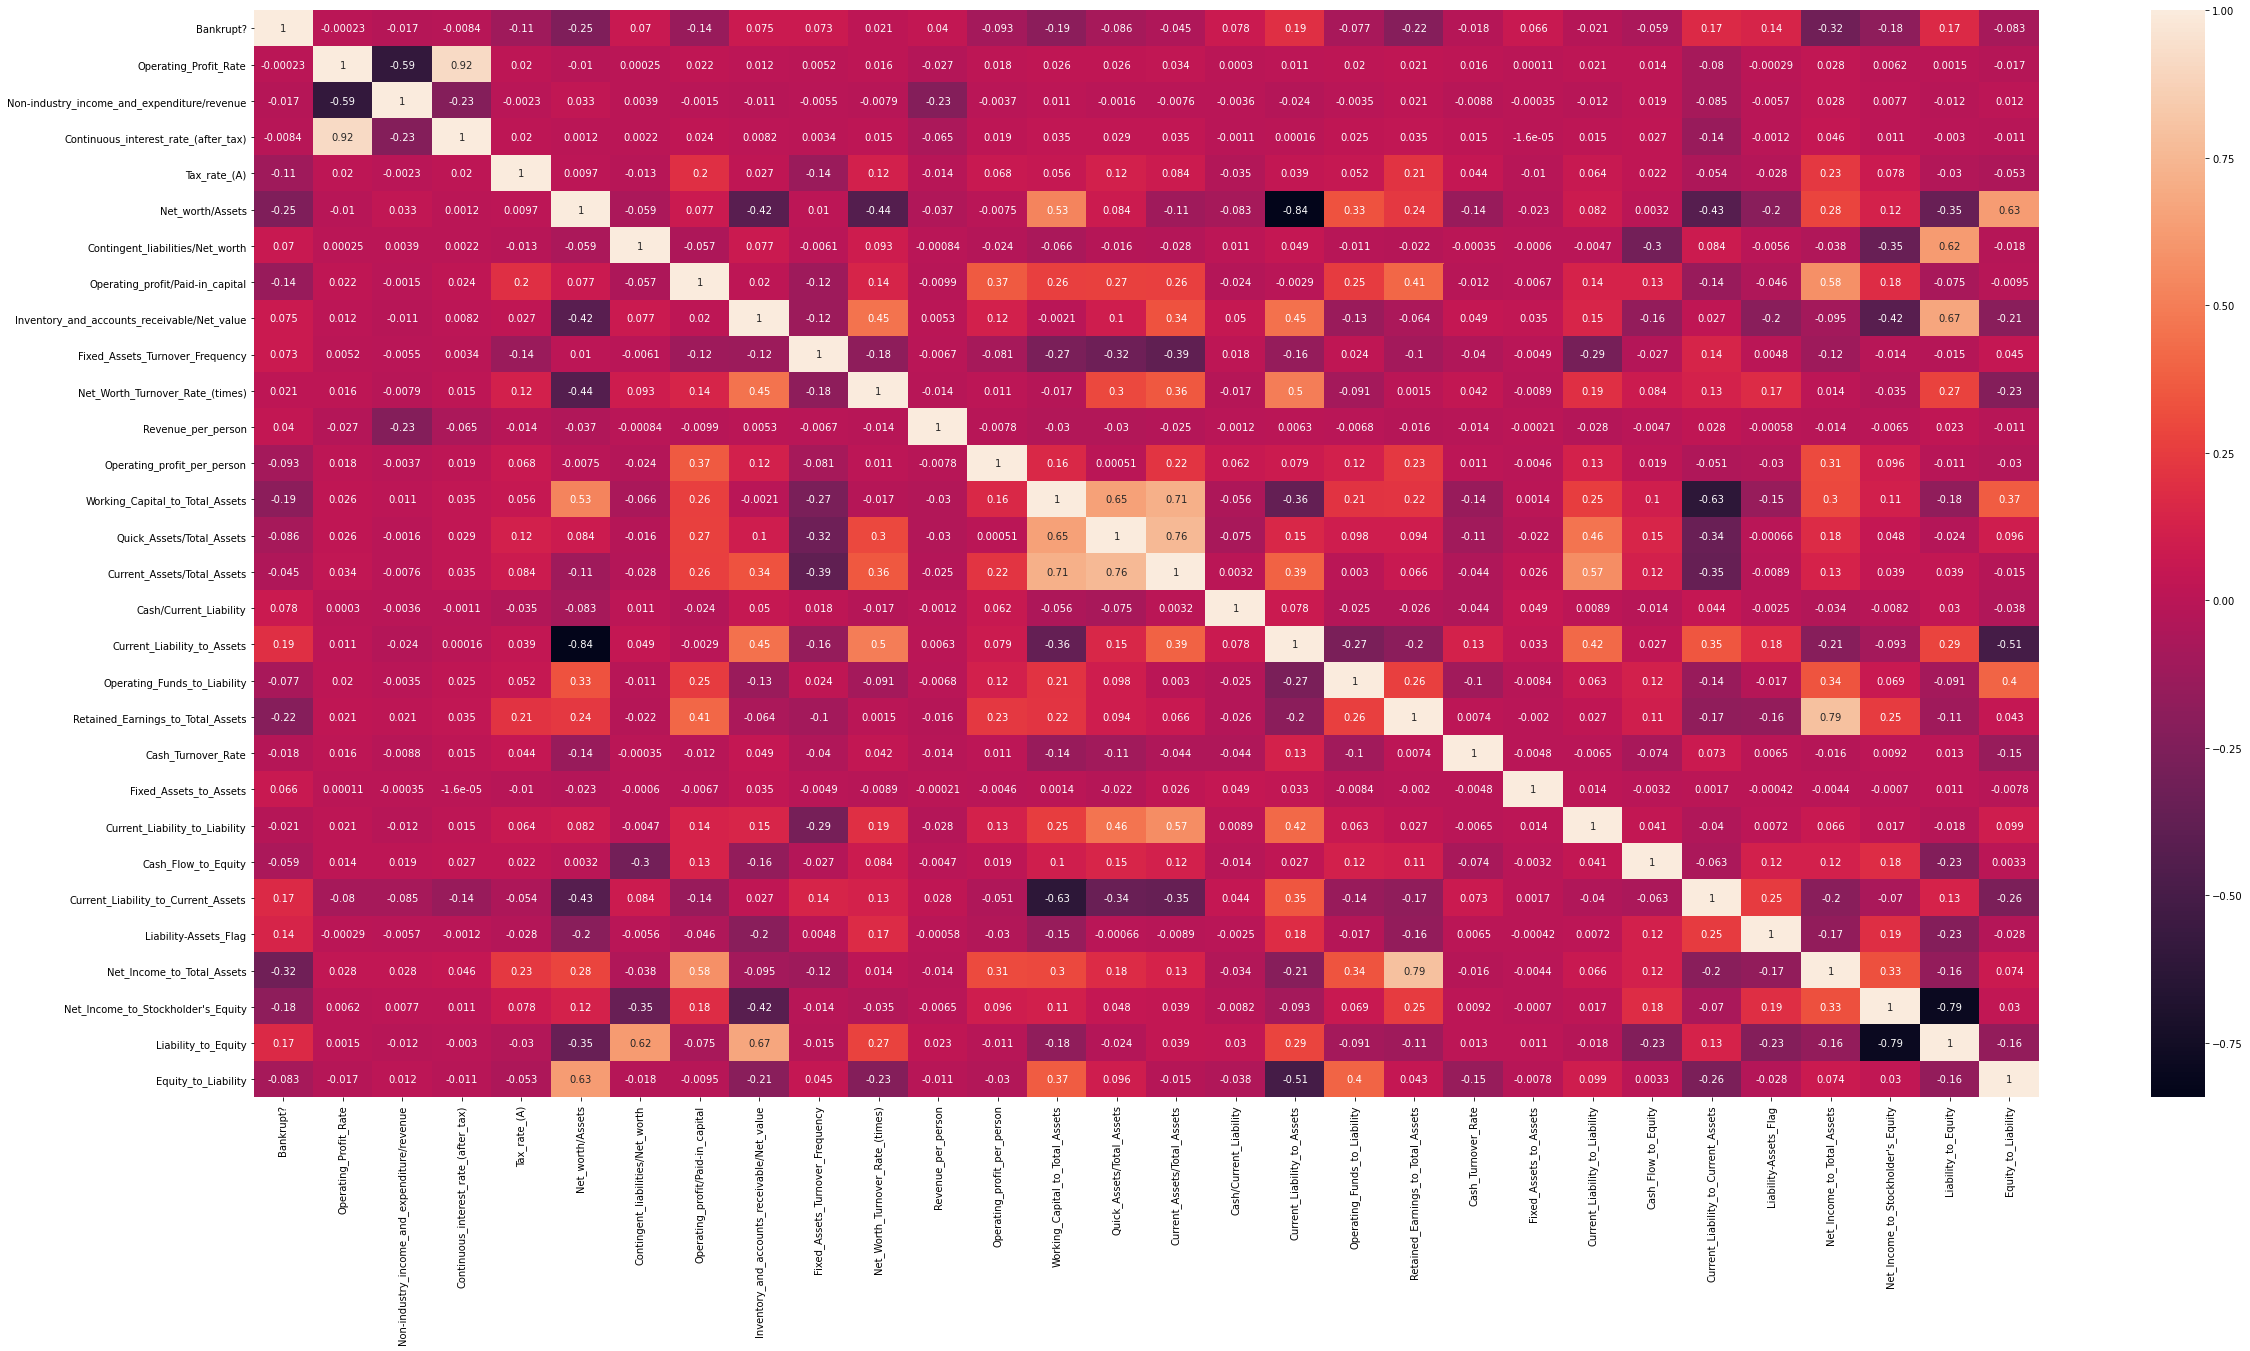

In [42]:
corr_sel = sel_data.corr()
plt.figure(figsize=(40,20))
sns.heatmap(corr_sel, annot=True)

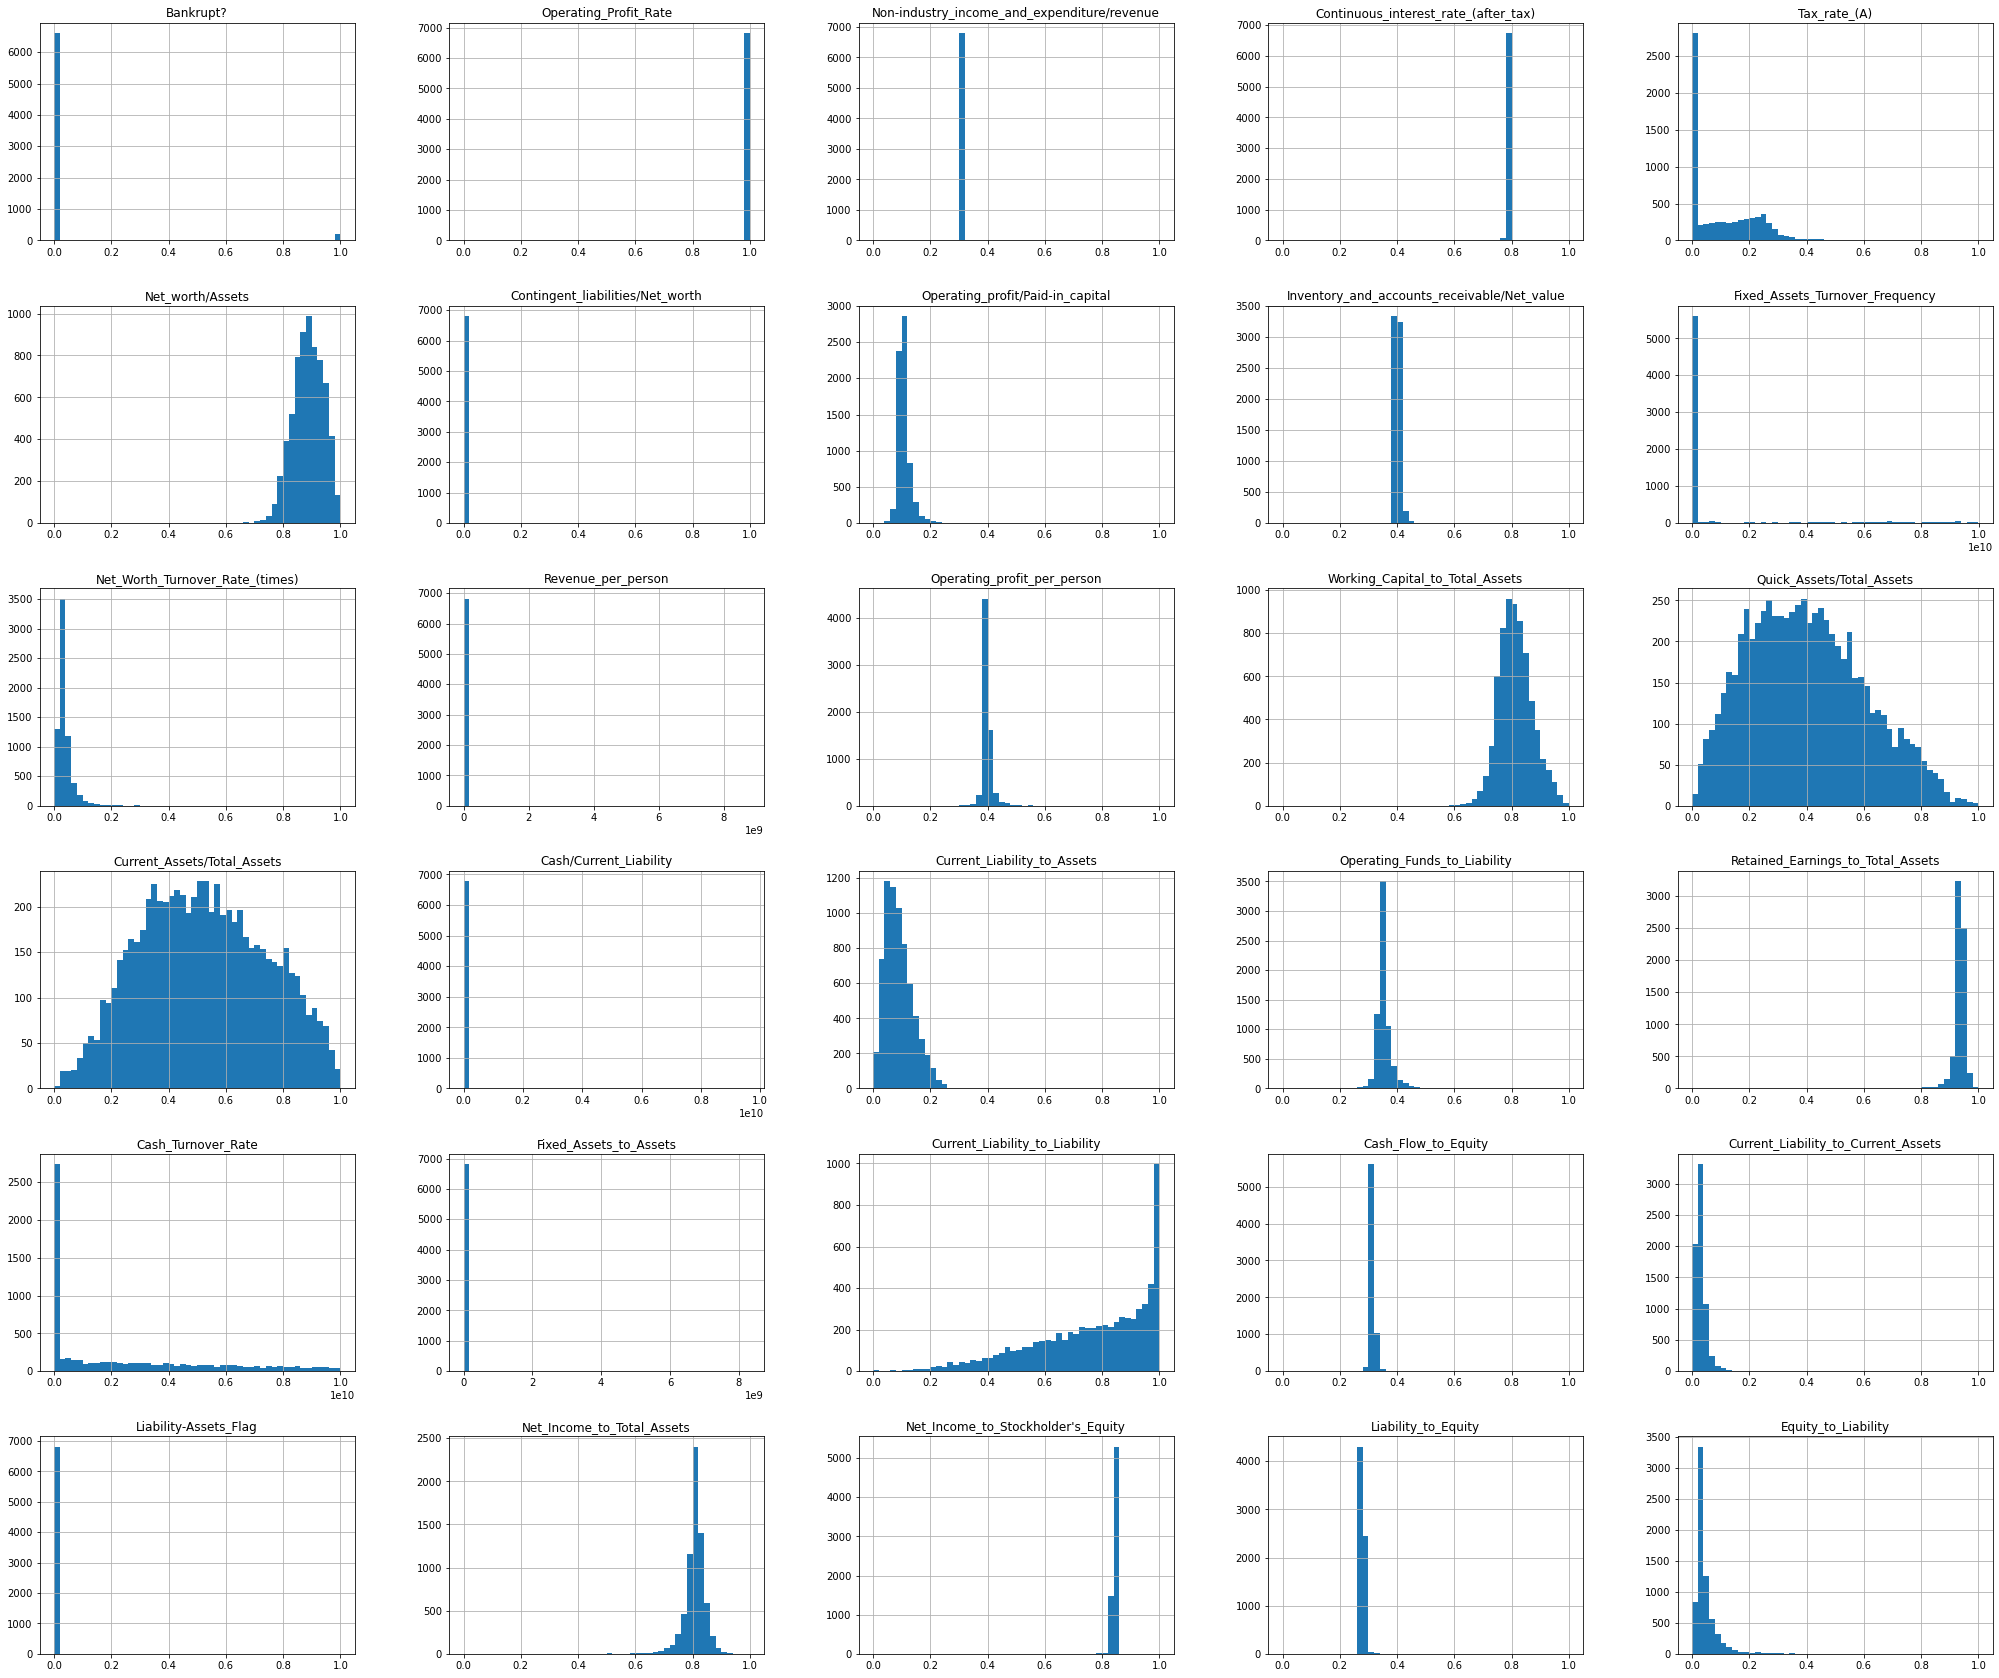

In [66]:
sel_data.hist(figsize=(35,30),bins=50)
plt.show()

#### Box plots for Analysis
I have seperated the analysis into 4 Major Categories utilizing the Boxplot on Bankrupt vs Survived companies:
- Assets
- Liabilities
- Accounting
- Operation

In [59]:
di = {0:'No', 1:'Yes'}
cat_data = sel_data.replace({'Bankrupt?':di})

,Bankrupt?,Operating_Profit_Rate,Non-industry_income_and_expenditure/revenue,Continuous_interest_rate_(after_tax),Tax_rate_(A),Net_worth/Assets,Contingent_liabilities/Net_worth,Operating_profit/Paid-in_capital,Inventory_and_accounts_receivable/Net_value,Fixed_Assets_Turnover_Frequency,...,Cash_Turnover_Rate,Fixed_Assets_to_Assets,Current_Liability_to_Liability,Cash_Flow_to_Equity,Current_Liability_to_Current_Assets,Liability-Assets_Flag,Net_Income_to_Total_Assets,Net_Income_to_Stockholder's_Equity,Liability_to_Equity,Equity_to_Liability
0,Yes,0.998969,0.302646,0.780985,0.0,0.792424,0.006479,0.095885,0.398036,1.165007e-04,...,4.580000e+08,0.424206,0.676269,0.312905,0.118250,0,0.716845,0.827890,0.290202,0.016469
1,Yes,0.998946,0.303556,0.781506,0.0,0.828824,0.005835,0.093743,0.397725,7.190000e+08,...,2.490000e+09,0.468828,0.308589,0.314163,0.047775,0,0.795297,0.839969,0.283846,0.020794
2,Yes,0.998857,0.302035,0.780284,0.0,0.792484,0.006562,0.092318,0.406580,2.650000e+09,...,7.610000e+08,0.276179,0.446027,0.314515,0.025346,0,0.774670,0.836774,0.290189,0.016474
3,Yes,0.998700,0.303350,0.781241,0.0,0.848535,0.005366,0.077727,0.397925,9.150000e+09,...,2.030000e+09,0.559144,0.615848,0.302382,0.067250,0,0.739555,0.834697,0.281721,0.023982
4,Yes,0.998973,0.303475,0.781550,0.0,0.893491,0.006624,0.096927,0.400079,2.935211e-04,...,8.240000e+08,0.309555,0.975007,0.311567,0.047725,0,0.795016,0.839973,0.278514,0.035490


#### Assets Analysis

In this section, there are 4 sub-categories which divides the data-set into assets classes. 
- Current_Assets/Total_Assets = A ratio between current assets and total assets is a ratio to determine economic value for or within one year to all current assets. Ratio helps to measure the short-term liquidity of the company, or its ability to generate enough cash to pay off all debts should they become due at once. 
- Quick Assets/Total Assets = Similar to Current Assets ratio, Quick Assets ratio helps to measure the liquidity of the company but excluding inventory, and other less liquid assets and focuses on the company's most liquid assets.
- Net worth/Assets = Measures the amount of equity the business has when compared to the total assets owned by the business. Higher Net_worth to Asset ratio, the less leveraged the company is, meaning that a larger percentage of its assets are owned by the company and its investors
- Working Capital/Total Assets = A ratio that compares the net liquid assets to the total assets of the firm. Working capital is the difference between current assets and current liabilities, so the ratio detrmines the short-term company's solvency

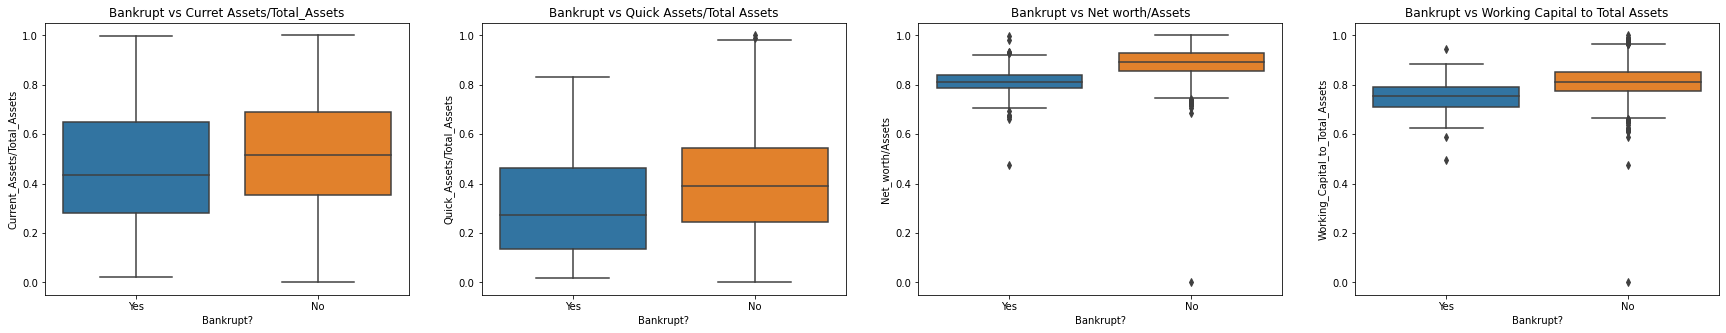

In [69]:
fig, axs = plt.subplots(ncols=4, figsize=(30,5))
sns.boxplot(x='Bankrupt?',y='Current_Assets/Total_Assets', data=cat_data, ax=axs[0])
sns.boxplot(x='Bankrupt?',y='Quick_Assets/Total_Assets', data=cat_data, ax=axs[1])
sns.boxplot(x='Bankrupt?',y='Net_worth/Assets', data=cat_data, ax=axs[2])
sns.boxplot(x='Bankrupt?',y='Working_Capital_to_Total_Assets', data=cat_data, ax=axs[3])
axs[0].set_title('Bankrupt vs Curret Assets/Total_Assets');
axs[1].set_title('Bankrupt vs Quick Assets/Total Assets');
axs[2].set_title('Bankrupt vs Net worth/Assets');
axs[3].set_title('Bankrupt vs Working Capital to Total Assets');


From the above boxplots we can see patterns in the assets ratios from Bankrupt vs Surviving companies.

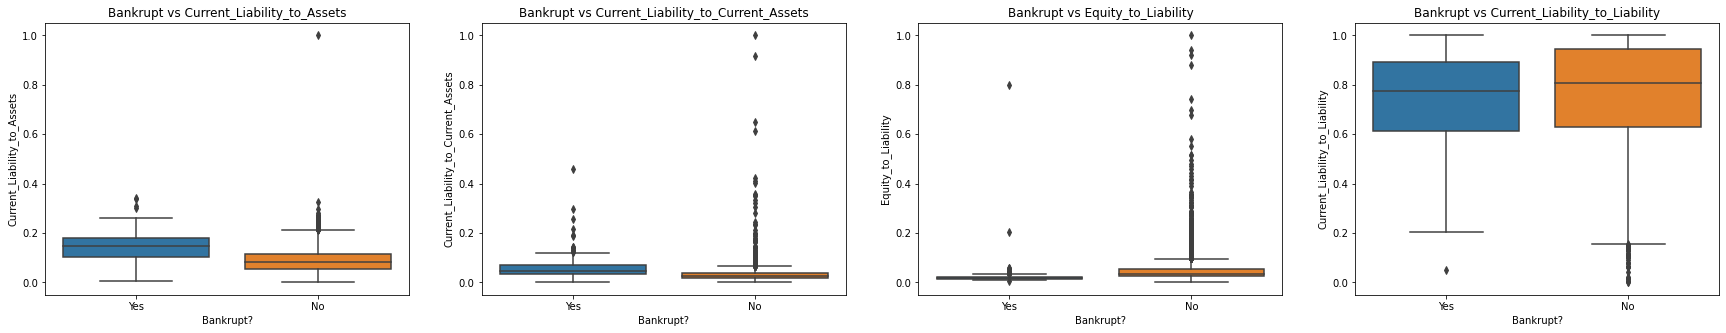

In [95]:
fig, axs = plt.subplots(ncols=4, figsize=(30,5))
sns.boxplot(x='Bankrupt?',y='Current_Liability_to_Assets', data=cat_data, ax=axs[0])
sns.boxplot(x='Bankrupt?',y='Current_Liability_to_Current_Assets', data=cat_data, ax=axs[1])
sns.boxplot(x='Bankrupt?',y='Equity_to_Liability', data=cat_data, ax=axs[2])
sns.boxplot(x='Bankrupt?',y='Current_Liability_to_Liability', data=cat_data, ax=axs[3])
axs[0].set_title('Bankrupt vs Current_Liability_to_Assets');
axs[1].set_title('Bankrupt vs Current_Liability_to_Current_Assets');
axs[2].set_title('Bankrupt vs Equity_to_Liability');
axs[3].set_title('Bankrupt vs Current_Liability_to_Liability');

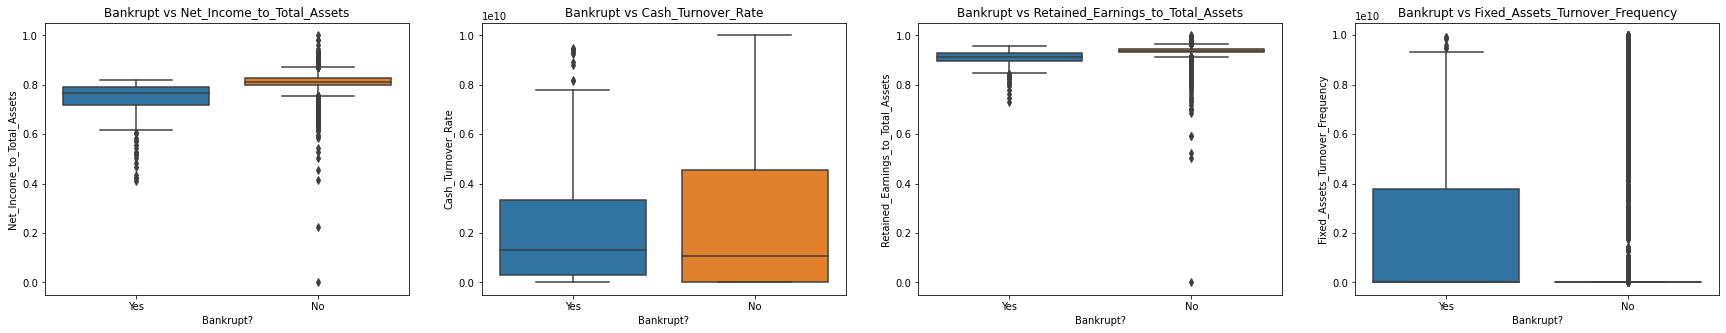

In [93]:
fig, axs = plt.subplots(ncols=4, figsize=(30,5))
sns.boxplot(x='Bankrupt?',y='Net_Income_to_Total_Assets', data=cat_data, ax=axs[0])
sns.boxplot(x='Bankrupt?',y='Cash_Turnover_Rate', data=cat_data, ax=axs[1])
sns.boxplot(x='Bankrupt?',y='Retained_Earnings_to_Total_Assets', data=cat_data, ax=axs[2])
sns.boxplot(x='Bankrupt?',y='Fixed_Assets_Turnover_Frequency', data=cat_data, ax=axs[3])
axs[0].set_title('Bankrupt vs Net_Income_to_Total_Assets');
axs[1].set_title('Bankrupt vs Cash_Turnover_Rate');
axs[2].set_title('Bankrupt vs Retained_Earnings_to_Total_Assets');
axs[3].set_title('Bankrupt vs Fixed_Assets_Turnover_Frequency');

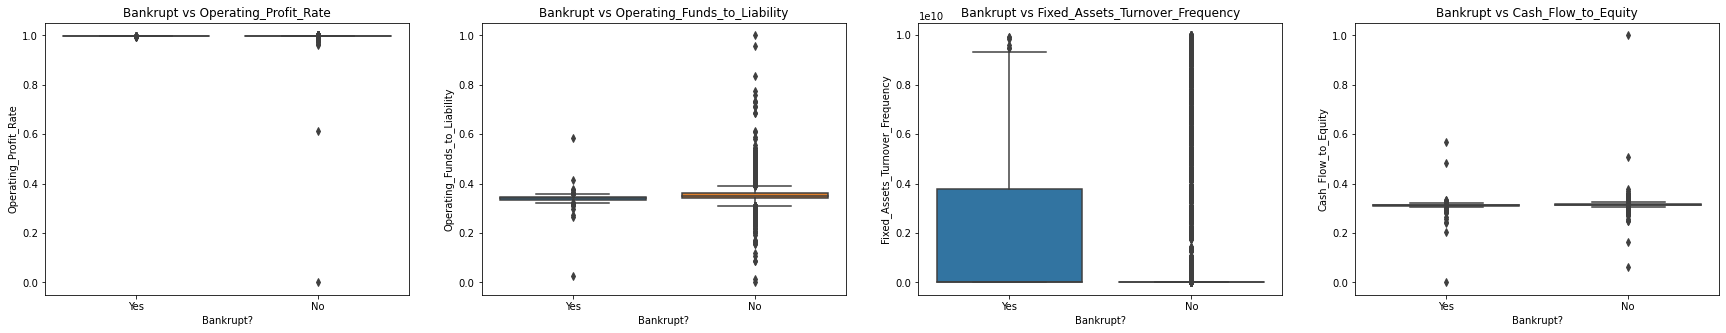

In [67]:
fig, axs = plt.subplots(ncols=4, figsize=(30,5))
sns.boxplot(x='Bankrupt?',y='Operating_Profit_Rate', data=cat_data, ax=axs[0])
sns.boxplot(x='Bankrupt?',y='Operating_Funds_to_Liability', data=cat_data, ax=axs[1])
sns.boxplot(x='Bankrupt?',y='Fixed_Assets_Turnover_Frequency', data=cat_data, ax=axs[2])
sns.boxplot(x='Bankrupt?',y='Cash_Flow_to_Equity', data=cat_data, ax=axs[3])
axs[0].set_title('Bankrupt vs Operating_Profit_Rate');
axs[1].set_title('Bankrupt vs Operating_Funds_to_Liability');
axs[2].set_title('Bankrupt vs Fixed_Assets_Turnover_Frequency');
axs[3].set_title('Bankrupt vs Cash_Flow_to_Equity');